In [ ]:
import csv
import pandas as pd

csv_file = "planification.csv"
# csv_file = "/Users/madalina/Documents/M1TAL/stage_GC/pro_text/predictions/production_p+s1.csv"

def process_row(row, data):
    if row[3] not in data:
        data[row[3]] = [row[i] for i in range(4, 15)]
        data[row[3]].append(row[17])
        # data[row[3]].append(row[18]) # this is the type of burst (P, R, ER)
        char_burst = [(row[15], row[16], row[19])]
        data[row[3]].append(char_burst)
    else:
        char_burst = (row[15], row[16], row[19])
        data[row[3]][-1].append(char_burst)
    return data

def process_csv(reader):
    people = {}
    for row in reader:
        if row[0] not in people:
            data = {}
            data = process_row(row, data)
            people[row[0]] = data
        else:
            data = people[row[0]]
            data = process_row(row, data)
            people[row[0]] = data
    return people

def read_csv(csv_file):
    with open(csv_file, "r") as f:
        reader = csv.reader(f)
        next(reader)  # skip the header
        people = process_csv(reader)
    return people

def extract_features(burst_data):
    burstStart = float(burst_data[0])
    burstDur = float(burst_data[1])
    pauseDur = float(burst_data[2])  # This is the target we want to predict
    cycleDur = float(burst_data[3])
    burstPct = float(burst_data[4])
    pausePct = float(burst_data[5])
    totalActions = int(burst_data[6])
    totalChars = int(burst_data[7])
    finalChars = int(burst_data[8])
    totalDeletions = int(burst_data[9])
    innerDeletions = int(burst_data[10])
    docLen = int(burst_data[11])

    charBursts = burst_data[12]  # This is the list of tuples

    # Feature extraction from charBurst
    avg_shift = sum(abs(int(end) - int(start)) for start, end, _ in charBursts) / len(charBursts) # not sure if good metric
    num_actions = len(charBursts)

    return {
        # 'burstStart': burstStart,
        # 'burstDur': burstDur,
        # 'cycleDur': cycleDur,
        # 'burstPct': burstPct,
        # 'pausePct': pausePct,
        'totalActions': totalActions,
        'totalChars': totalChars,
        'finalChars': finalChars,
        'totalDeletions': totalDeletions,
        'innerDeletions': innerDeletions,
        'docLen': docLen,
        'avg_shift': avg_shift,
        'num_actions': num_actions,
        'pauseDur': pauseDur # This is the target we want to predict
    }

def main():
    people = read_csv(csv_file)
    dataset = []
    for person in people:
        for burst_id in people[person]:
            features = extract_features(people[person][burst_id])
            dataset.append(features)
    df = pd.DataFrame(dataset)
    return df

if __name__ == "__main__":
    main()


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

df = main()
X = df.drop(columns=['pauseDur'])
y = df['pauseDur']
X_training, X_testing, y_training, y_testing = train_test_split(
    X, y, test_size=0.2
)

print(f'X_training shape: {X_training.shape}')
print(f'y_training shape: {y_training.shape}')

X_training shape: (4429, 8)
y_training shape: (4429,)


In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(16, input_shape=(8,), activation="relu"))

model.add(tf.keras.layers.Dense(1))

# Train neural network
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mean_absolute_error"]
)
model.fit(X_training, y_training, epochs=20,batch_size=8, verbose=2)

# Evaluate how well model performs
model.evaluate(X_testing, y_testing, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
554/554 - 3s - 5ms/step - loss: 308.4567 - mean_absolute_error: 8.9029
Epoch 2/20
554/554 - 1s - 2ms/step - loss: 173.1596 - mean_absolute_error: 6.2908
Epoch 3/20
554/554 - 1s - 2ms/step - loss: 170.3834 - mean_absolute_error: 6.2157
Epoch 4/20
554/554 - 1s - 2ms/step - loss: 169.2758 - mean_absolute_error: 6.2275
Epoch 5/20
554/554 - 1s - 2ms/step - loss: 168.3848 - mean_absolute_error: 6.2478
Epoch 6/20
554/554 - 1s - 2ms/step - loss: 164.1042 - mean_absolute_error: 6.1646
Epoch 7/20
554/554 - 1s - 1ms/step - loss: 164.7005 - mean_absolute_error: 6.1492
Epoch 8/20
554/554 - 1s - 2ms/step - loss: 161.8641 - mean_absolute_error: 6.0645
Epoch 9/20
554/554 - 1s - 2ms/step - loss: 159.9357 - mean_absolute_error: 6.0214
Epoch 10/20
554/554 - 1s - 1ms/step - loss: 164.4368 - mean_absolute_error: 6.3538
Epoch 11/20
554/554 - 1s - 1ms/step - loss: 159.2938 - mean_absolute_error: 6.1236
Epoch 12/20
554/554 - 1s - 1ms/step - loss: 159.3102 - mean_absolute_error: 6.0677
Epoch 13/20
5

[174.635498046875, 7.025776386260986]

In [ ]:
from sklearn.preprocessing import StandardScaler

X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_testing = scaler.transform(X_testing)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(64, input_shape=(X_training.shape[1],), activation="relu"))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(1))

# Train neural network
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mean_absolute_error"]
)
history = model.fit(X_training, y_training, epochs=100, batch_size=8, verbose=2, validation_split=0.2)

# Evaluate how well model performs
evaluation = model.evaluate(X_testing, y_testing, verbose=2)
print(f"Test Loss: {evaluation[0]}, Test MAE: {evaluation[1]}")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


443/443 - 2s - 5ms/step - loss: 160.6373 - mean_absolute_error: 5.9334 - val_loss: 151.5936 - val_mean_absolute_error: 5.8667
Epoch 2/100
443/443 - 1s - 2ms/step - loss: 154.9352 - mean_absolute_error: 5.9580 - val_loss: 150.8392 - val_mean_absolute_error: 5.6966
Epoch 3/100
443/443 - 1s - 2ms/step - loss: 154.6565 - mean_absolute_error: 5.9511 - val_loss: 151.0924 - val_mean_absolute_error: 6.2844
Epoch 4/100
443/443 - 1s - 3ms/step - loss: 153.3045 - mean_absolute_error: 5.9841 - val_loss: 149.9229 - val_mean_absolute_error: 6.1359
Epoch 5/100
443/443 - 1s - 3ms/step - loss: 153.4185 - mean_absolute_error: 6.0112 - val_loss: 149.8470 - val_mean_absolute_error: 5.8838
Epoch 6/100
443/443 - 1s - 3ms/step - loss: 153.2973 - mean_absolute_error: 5.9929 - val_loss: 151.2866 - val_mean_absolute_error: 5.4960
Epoch 7/100
443/443 - 1s - 3ms/step - loss: 153.2301 - mean_absolute_error: 5.9572 - val_loss: 150.0102 - val_mean_absolute_error: 5.9305
Epoch 8/100
443/443 - 2s - 4ms/step - loss: 15

In [ ]:
y_pred = model.predict(X_testing)

# If you want to measure the performance
from sklearn.metrics import r2_score

r2 = r2_score(y_testing, y_pred)
print(f"R² Score: {r2:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R² Score: -0.0259


pauseDur          1.000000
avg_shift        -0.015923
innerDeletions   -0.028829
docLen           -0.032382
totalDeletions   -0.032958
num_actions      -0.036836
finalChars       -0.046699
totalChars       -0.047638
totalActions     -0.052632
Name: pauseDur, dtype: float64


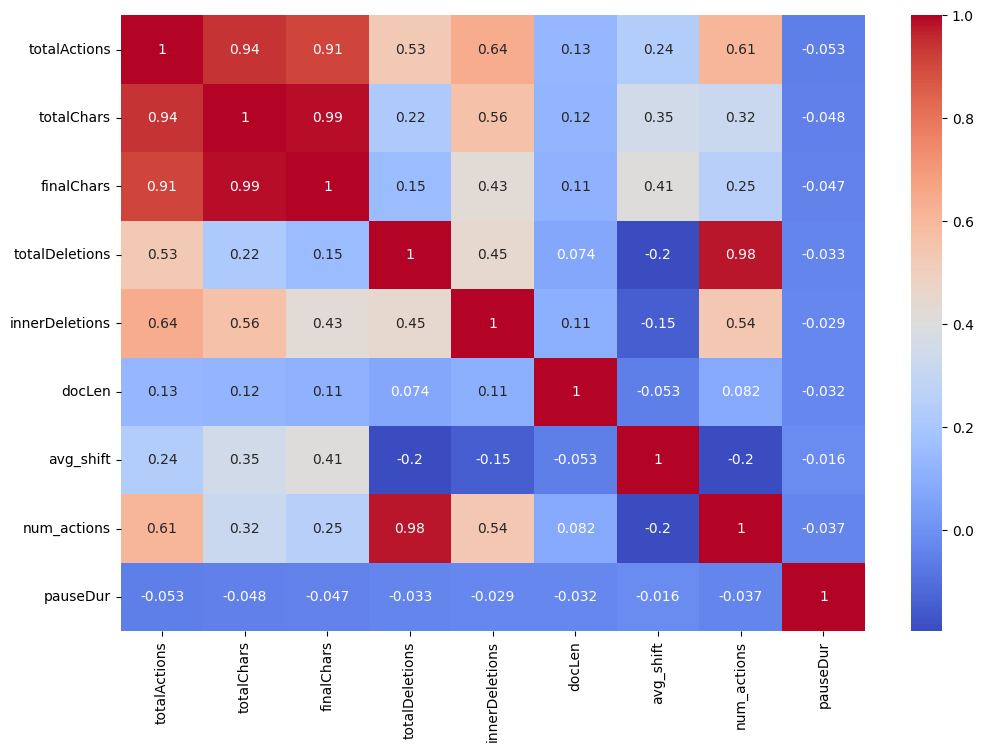

[]
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


554/554 - 1s - 3ms/step - loss: 199.9331 - mean_absolute_error: 6.9017
Epoch 2/100
554/554 - 1s - 1ms/step - loss: 193.8678 - mean_absolute_error: 6.4475
Epoch 3/100
554/554 - 1s - 2ms/step - loss: 188.4609 - mean_absolute_error: 6.0200
Epoch 4/100
554/554 - 1s - 1ms/step - loss: 183.6139 - mean_absolute_error: 5.6086
Epoch 5/100
554/554 - 1s - 1ms/step - loss: 179.2756 - mean_absolute_error: 5.3105
Epoch 6/100
554/554 - 1s - 1ms/step - loss: 175.4178 - mean_absolute_error: 5.1221
Epoch 7/100
554/554 - 1s - 2ms/step - loss: 172.0378 - mean_absolute_error: 5.0187
Epoch 8/100
554/554 - 1s - 2ms/step - loss: 169.0339 - mean_absolute_error: 4.9662
Epoch 9/100
554/554 - 1s - 2ms/step - loss: 166.3882 - mean_absolute_error: 4.9512
Epoch 10/100
554/554 - 1s - 3ms/step - loss: 164.0662 - mean_absolute_error: 4.9603
Epoch 11/100
554/554 - 1s - 2ms/step - loss: 162.0280 - mean_absolute_error: 4.9868
Epoch 12/100
554/554 - 1s - 1ms/step - loss: 160.3266 - mean_absolute_error: 5.0371
Epoch 13/100


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Correlation Analysis
correlation_matrix = df.corr()
print(correlation_matrix['pauseDur'].sort_values(ascending=False))

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Select features with high correlation with the target variable
high_corr_features = correlation_matrix.index[abs(correlation_matrix['pauseDur']) > 0.5].tolist()
high_corr_features.remove('pauseDur')
X = df[high_corr_features]

X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.2, random_state=42)

print(tf.config.list_physical_devices('GPU'))

# Create a neural network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(16, input_shape=(X_training.shape[1],), activation="relu"))
model.add(tf.keras.layers.Dense(1))

# Train neural network
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"])
model.fit(X_training, y_training, epochs=100, batch_size=8, verbose=2)

# Evaluate how well model performs
model.evaluate(X_testing, y_testing, verbose=2)

y_pred = model.predict(X_testing)
r2 = r2_score(y_testing, y_pred)
print(f"R² Score: {r2}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
# Feature Importance using Random Forest
df = main()
X = df.drop(columns=['pauseDur'])
y = df['pauseDur']
model_rf = RandomForestRegressor()
model_rf.fit(X, y)
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")

# Select top features
top_features = [X.columns[indices[f]] for f in range(5)]  # Select top 5 features
X = X[top_features]

X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_training_scaled = scaler.fit_transform(X_training)
X_testing_scaled = scaler.transform(X_testing)

# Create a neural network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, input_shape=(X_training_scaled.shape[1],), activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(1))

# Train neural network
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mean_squared_error",
              metrics=["mean_absolute_error"])
# model.fit(X_training_scaled, y_training, epochs=50, batch_size=8, verbose=2)

# Evaluate how well model performs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_training_scaled, y_training, epochs=100, batch_size=8,
          validation_split=0.2, callbacks=[early_stopping], verbose=2)

y_pred = model.predict(X_testing_scaled)
r2 = r2_score(y_testing, y_pred)
print(f"R² Score: {r2}")

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_rf, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {scores}")
print(f"Mean Cross-Validation R² Score: {np.mean(scores)}")

Feature ranking:
1. feature docLen (0.5314811733186876)
2. feature avg_shift (0.15546705319218165)
3. feature finalChars (0.07901703600275611)
4. feature totalActions (0.07165771763357906)
5. feature totalChars (0.060565082758211375)
6. feature totalDeletions (0.03715908151765566)
7. feature num_actions (0.03681434394686074)
8. feature innerDeletions (0.02783851163006785)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


443/443 - 6s - 13ms/step - loss: 161.1850 - mean_absolute_error: 5.8898 - val_loss: 152.6322 - val_mean_absolute_error: 5.7718
Epoch 2/100
443/443 - 1s - 3ms/step - loss: 154.1288 - mean_absolute_error: 5.9335 - val_loss: 151.7303 - val_mean_absolute_error: 5.8035
Epoch 3/100
443/443 - 1s - 3ms/step - loss: 153.1353 - mean_absolute_error: 5.9635 - val_loss: 150.6784 - val_mean_absolute_error: 6.0149
Epoch 4/100
443/443 - 1s - 2ms/step - loss: 152.7129 - mean_absolute_error: 6.0151 - val_loss: 150.4288 - val_mean_absolute_error: 5.9041
Epoch 5/100
443/443 - 1s - 2ms/step - loss: 152.3276 - mean_absolute_error: 5.9780 - val_loss: 150.2908 - val_mean_absolute_error: 6.0529
Epoch 6/100
443/443 - 1s - 3ms/step - loss: 151.8649 - mean_absolute_error: 5.9892 - val_loss: 151.4161 - val_mean_absolute_error: 6.2925
Epoch 7/100
443/443 - 1s - 3ms/step - loss: 152.1783 - mean_absolute_error: 6.0475 - val_loss: 150.6062 - val_mean_absolute_error: 5.9259
Epoch 8/100
443/443 - 1s - 2ms/step - loss: 1

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Assuming df is your DataFrame with 'pauseDur' as the target variable
df = main()
X = df.drop(columns=['pauseDur'])
y = df['pauseDur']

# Create sequences (e.g., sequence length of 3)
timesteps = 3
X_seq = np.array([X.iloc[i:i + timesteps].values for i in range(len(X) - timesteps)])
y_seq = y.iloc[timesteps:].values

# Split the data into training and testing sets
X_training, X_testing, y_training, y_testing = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_training.shape[1], X_training.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
model.fit(X_training, y_training, epochs=100, batch_size=8, verbose=2, validation_split=0.2)

# Evaluate the model
model.evaluate(X_testing, y_testing, verbose=2)

# Predict and calculate R²
y_pred = model.predict(X_testing)
r2 = r2_score(y_testing, y_pred)
print(f"R² Score: {r2}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
443/443 - 7s - 16ms/step - loss: 378.3056 - mean_absolute_error: 11.3825 - val_loss: 149.9618 - val_mean_absolute_error: 6.3963
Epoch 2/100
443/443 - 2s - 5ms/step - loss: 173.7238 - mean_absolute_error: 7.4526 - val_loss: 148.9757 - val_mean_absolute_error: 5.6356
Epoch 3/100
443/443 - 2s - 5ms/step - loss: 183.0998 - mean_absolute_error: 7.7872 - val_loss: 160.5694 - val_mean_absolute_error: 6.1927
Epoch 4/100
443/443 - 4s - 8ms/step - loss: 165.1220 - mean_absolute_error: 7.2602 - val_loss: 149.5305 - val_mean_absolute_error: 5.3263
Epoch 5/100
443/443 - 4s - 8ms/step - loss: 173.6509 - mean_absolute_error: 7.4536 - val_loss: 201.3260 - val_mean_absolute_error: 8.4323
Epoch 6/100
443/443 - 3s - 7ms/step - loss: 163.2060 - mean_absolute_error: 7.0613 - val_loss: 137.1781 - val_mean_absolute_error: 5.3609
Epoch 7/100
443/443 - 1s - 3ms/step - loss: 158.7651 - mean_absolute_error: 6.9609 - val_loss: 153.1149 - val_mean_absolute_error: 7.4561
Epoch 8/100
443/443 - 1s - 3ms/s